La parte interesante de MESF es eliminar la autocorrelación implícita de los datos debido a la posición geográfica (en regresión lineal se supone que las observaciones son indepenientes). 

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append(
    "/Users/mateo/Documents/Máster Big Data/TFM/codes/urbana-barcelona-master/src"
)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

from libpysal.weights import Queen, KNN, Gabriel
import networkx as nx

from urbana.models.plot_predictions import PredictedAccuracy
from urbana.constants import DIR_REPO, DIR_DATA

In [5]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

YEAR = 2023  # ALLOWED_YEARS = [2017, 2018, 2023]
MONTH = 12

OUTPUT_WARNINGS = False
SAVE_FIGS = False
FIT_INTERCEPT = True

VARIABLE_TO_PREDICT = "Airbnb_Number"

# Number of selected variables in these categories
K_EDUCATION = 1
K_AGE = 2
K_NATIONALITY = 2
K_RENT = 1
K_POI = 10

# Warnings
if not OUTPUT_WARNINGS:
    import warnings

    warnings.filterwarnings("ignore")

# Parameter check
ALLOWED_YEARS = [2017, 2018, 2023]

if YEAR not in ALLOWED_YEARS:
    raise Exception("Please select a year within: {}".format(ALLOWED_YEARS))

if YEAR == 2018 and MONTH == 3:
    raise Exception(
        "Month 3 (March) is not available for 2018. Please choose a different month."
    )

# Create folders to store the data
DIR_VAR = DIR_DATA / "processed/{}".format(VARIABLE_TO_PREDICT)
DIR_MONTH = DIR_VAR / "{}_{:02d}".format(YEAR, MONTH)
DIR_MESF = DIR_MONTH / "08_mesf"

if SAVE_FIGS:
    folder_list = [
        DIR_MESF,
        DIR_MESF / "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

PATH_TO_FILE = DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH)
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "00acquisition.ipynb" with the same date and "SAVE_DATA" set to True'
    )

PATH_TO_FILE = DIR_MONTH / "01_linear/coefficients.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebook "01linear.ipynb" with the same date and "SAVE_MODEL" set to True'
    )

# Data Import

In [6]:
sect = pd.read_csv(DIR_DATA / "interim/sections_{}_{:02d}.csv".format(YEAR, MONTH))
sect.set_index("Tag", inplace=True)
sect.drop(
    [
        "N_district",
        "N_neighbourhood",
        "N_section",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
        "Percentage_Age_25_39",
    ],
    axis=1,
    inplace=True,
)

X = sect.drop(VARIABLE_TO_PREDICT, axis=1)
y = sect[VARIABLE_TO_PREDICT]

geo_info = gpd.read_file(DIR_DATA / "interim/sections_geo.json")
geo_info.set_index("Tag", inplace=True)
geo_info[VARIABLE_TO_PREDICT] = sect[VARIABLE_TO_PREDICT]

coords = np.column_stack(
    [geo_info["geometry"].centroid.x, geo_info["geometry"].centroid.y]
)

geo_info["centroid"] = geo_info["geometry"].centroid

# 1st model: All features

Moran’s Eigenvector Spatial Filtering (MESF) linear regression

Moran’s Eigenvector Spatial Filtering (MESF) is a spatial analysis technique used to model and adjust for spatial autocorrelation in linear regression models. Spatial autocorrelation refers to the correlation of a variable with itself through space. MESF utilizes eigenvectors derived from a spatial weights matrix to capture spatial structures and filter out spatial autocorrelation from the residuals of a regression model.

Mathematical Derivation: 

The MESF approach involves several key steps and components. Here, we provide a basic mathematical overview:

1. **Spatial Weights Matrix (W)**:
   The spatial weights matrix, $W$, describes the spatial relationship among observations. For instance, $w_{ij}$ could be defined based on the geographical distance or contiguity (neighbor status). In this case, 3 different weight matrix computations are going to be used: 

   - Queen contiguity: it creates an edge between a CBG polygon and other CBGs that share a common boundary or vertices → it prioritizes adjacent CBGs instead of size/shape. 

   - k-nearest neighbor: it considers a specified k-number of closest CBG centroids based on Euclidean distances as neighbors → accounts for both shape and size, while ensuring an equal number of neighbors across all nodes. (k=4)

   - Gabriel graph: it also factors in shape and size but goes a step further by considering the relative location of other points in the study area. It creates an edge between two points when no other node falls within a circle that is constructed with the line segment that connects them as the diameter. More restrictive than other SWMs. 

2. **Standardization of W**:
   The matrix is typically row-standardized such that each element is divided by the row sum:
   $$
   w_{ij}^{*} = \frac{w_{ij}}{\sum_{j=1}^n w_{ij}}
   $$

3. **Moran's I**:
   Moran's I is a measure of spatial autocorrelation, defined as:
   $$
   I = \frac{n}{\sum_{i=1}^n \sum_{j=1}^n w_{ij}} \frac{\sum_{i=1}^n \sum_{j=1}^n w_{ij} (X_i - \bar{X})(X_j - \bar{X})}{\sum_{i=1}^n (X_i - \bar{X})^2}
   $$
   where $X_i$ is the value of the variable at location $i$, $\bar{X}$ is the mean of $X$, and $n$ is the number of observations.

4. **Eigenvectors of W**:
   The eigenvectors of the matrix $W$ (or a function of it, such as $I-W$) are calculated. These eigenvectors represent the spatial patterns inherent in the data.

5. **Incorporating Eigenvectors into Regression**:
   Significant eigenvectors are selected based on criteria such as their association with the response variable. These eigenvectors are then used as additional explanatory variables in the regression model to account for spatial autocorrelation:

   $$ Y = X\beta + E\lambda + \epsilon  $$

   $$ Y = \beta_0 + \beta_1X_1 + \cdots + \beta_kX_k + \gamma_1E_1 + \cdots + \gamma_mE_m + \epsilon  $$

   where $E_m$ are the Moran eigenvectors and $\gamma_m$ are their corresponding coefficients.

Incorporating Moran's Eigenvectors into a regression analysis helps in controlling for spatial autocorrelation, leading to more reliable and interpretable results.

In [7]:
pd.set_option("display.max_columns", None)
geo_info.head()

,geometry,Airbnb_Number,centroid
Tag,,,
01_001,"POLYGON ((2.17575 41.37827, 2.17552 41.37865, ...",76,POINT (2.17722 41.37432)
01_002,"POLYGON ((2.17510 41.37905, 2.17470 41.37951, ...",61,POINT (2.17391 41.37793)
01_003,"POLYGON ((2.17220 41.37692, 2.17206 41.37696, ...",50,POINT (2.17199 41.37576)
01_004,"POLYGON ((2.16962 41.37847, 2.16962 41.37847, ...",82,POINT (2.16924 41.37642)
01_005,"POLYGON ((2.17366 41.38071, 2.17330 41.38113, ...",108,POINT (2.17277 41.37884)


## Spatial Weight Matrices 

In [8]:
# def plot_spatial_weights(gdf, w, title, n_color):
#     # Create a graph from the spatial weights matrix
#     G = nx.Graph()
#     for idx, neighbors in w.neighbors.items():
#         for neighbor in neighbors:
#             G.add_edge(idx, neighbor)

#     # Get positions from centroids of the geodataframe
#     pos = {
#         idx: (gdf.geometry[idx].centroid.x, gdf.geometry[idx].centroid.y)
#         for idx in G.nodes()
#     }

#     # Plot the map of sections
#     fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#     gdf.plot(ax=ax, color="lightgrey")

#     # Draw the network on top of the map
#     nx.draw(G, pos, node_size=15, node_color=n_color, with_labels=False, ax=ax)
#     nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

#     plt.title(title)
#     plt.show()

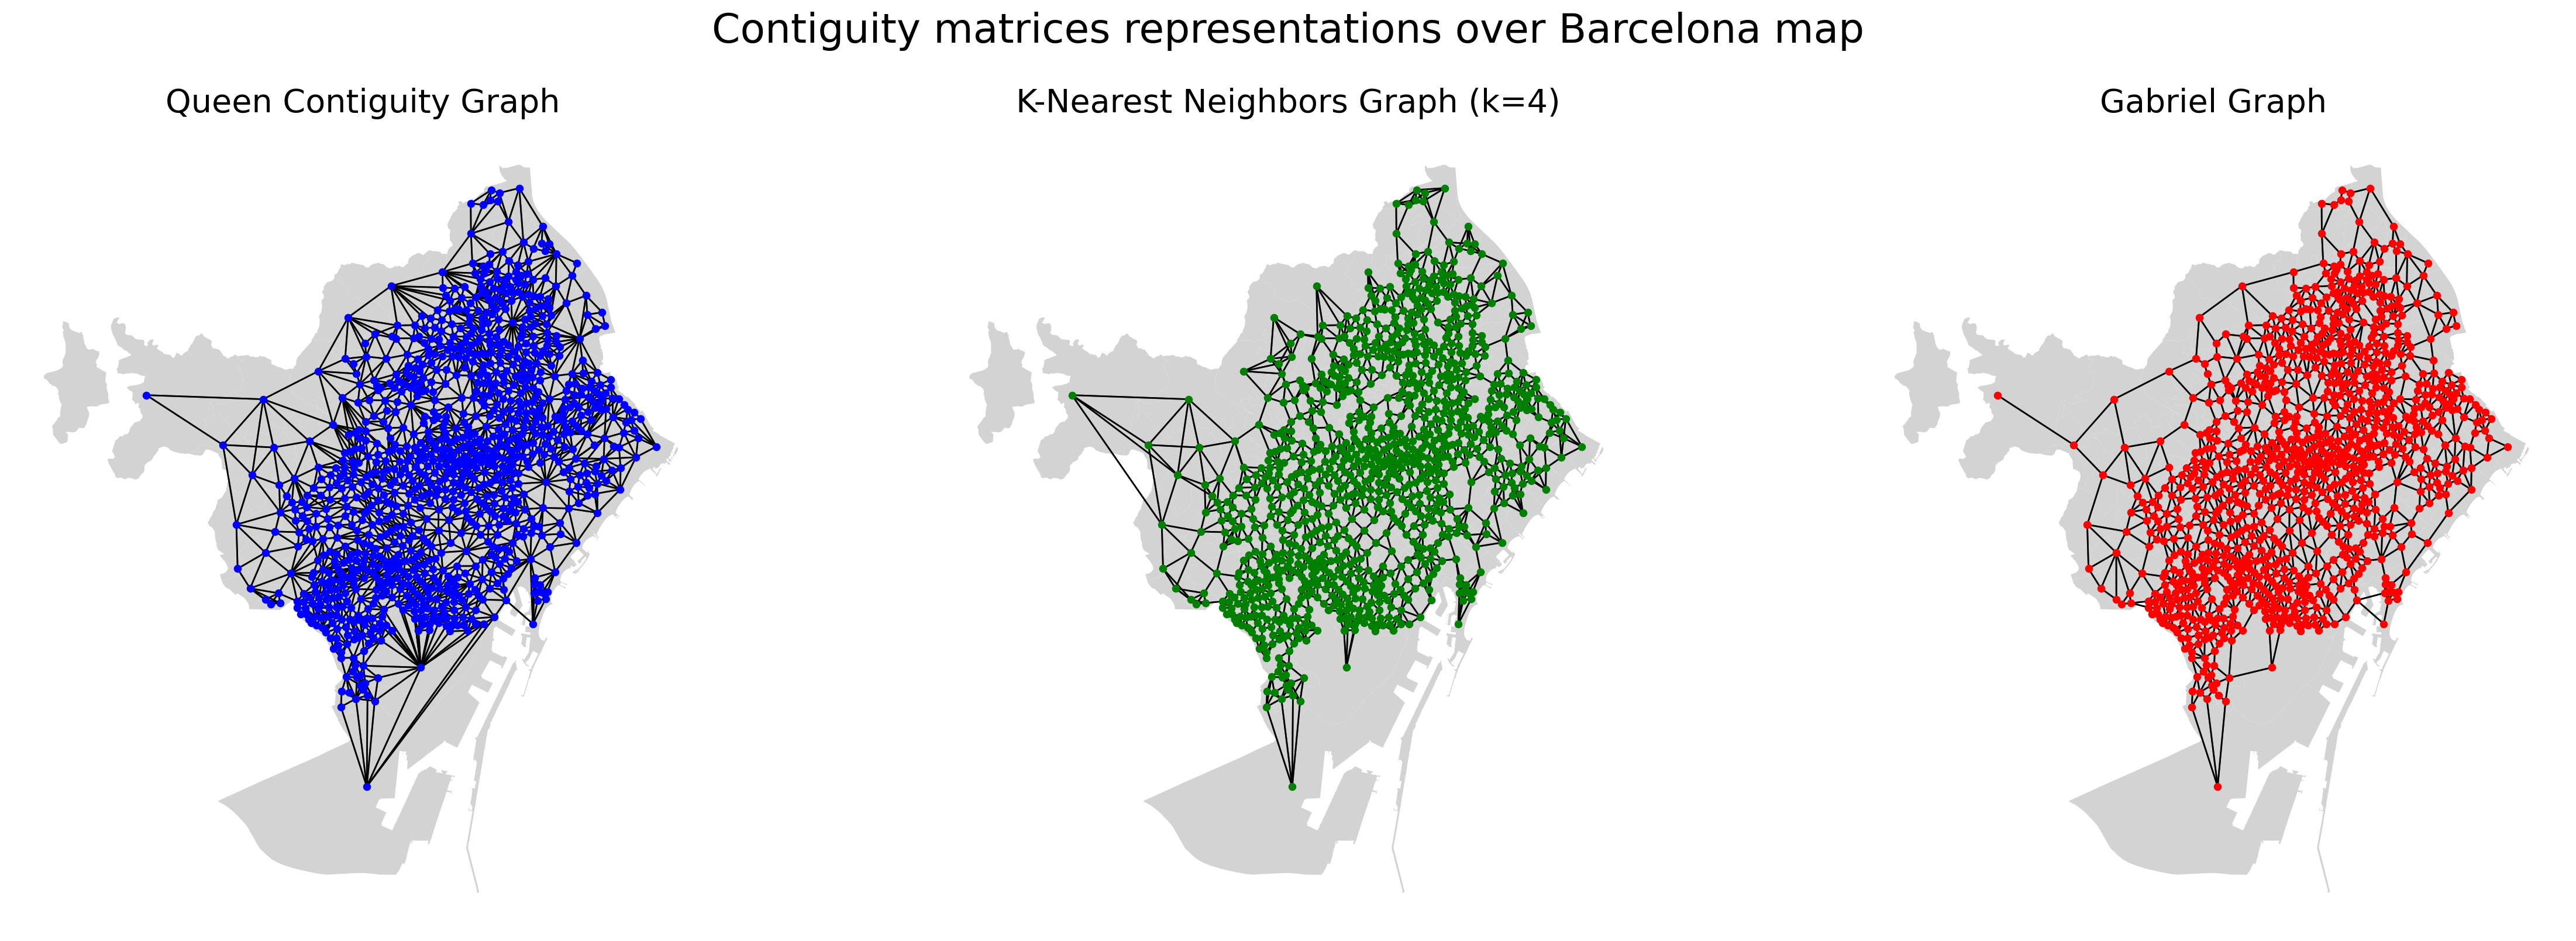

In [33]:
def plot_spatial_weights_on_map(gdf, w, ax, title, n_color):
    # Create a graph from the spatial weights matrix
    G = nx.Graph()
    for idx, neighbors in w.neighbors.items():
        for neighbor in neighbors:
            G.add_edge(idx, neighbor)

    # Get positions from centroids of the geodataframe
    pos = {
        idx: (gdf.geometry[idx].centroid.x, gdf.geometry[idx].centroid.y)
        for idx in G.nodes()
    }

    # Plot the map of sections
    gdf.plot(ax=ax, color="lightgrey")

    # Draw the network on top of the map
    nx.draw(G, pos, node_size=15, node_color=n_color, with_labels=False, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

    ax.set_title(title, fontsize=20)


# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle("Contiguity matrices representations over Barcelona map", fontsize=25, y=1)

# Queen contiguity weights
w_queen = Queen.from_dataframe(geo_info)
w_queen.transform = "R"  # row-standardizing the weight matrix
plot_spatial_weights_on_map(
    geo_info, w_queen, axes[0], "Queen Contiguity Graph", "blue"
)

# K-Nearest Neighbors weights (example with k=4)
w_knn = KNN.from_dataframe(geo_info, k=4)
w_knn.transform = "R"
plot_spatial_weights_on_map(
    geo_info, w_knn, axes[1], "K-Nearest Neighbors Graph (k=4)", "green"
)

# Gabriel Graph weights
geo_info_points = geo_info.copy()
geo_info_points.set_geometry("centroid", inplace=True)
w_gabriel = Gabriel.from_dataframe(geo_info_points)
w_gabriel.transform = "R"
plot_spatial_weights_on_map(geo_info, w_gabriel, axes[2], "Gabriel Graph", "red")

plt.tight_layout()

if SAVE_FIGS is True:
    plt.savefig(DIR_MESF / "connectivity_matrices.png", format="png")

plt.show()

## Moran's Eigenvectors

In [10]:
C = w_queen.full()[0]
print(C.shape)

M = np.eye(C.shape[0]) - np.ones(C.shape) / C.shape[0]
print(M.shape)

MCM = M @ C @ M
print(MCM.shape)

eigenvalues, E = np.linalg.eigh(MCM)

(1068, 1068)
(1068, 1068)
(1068, 1068)


In [11]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh


def compute_eigenvectors(w, num_eigs=10):
    C = w.full()[0]
    M = np.eye(C.shape[0]) - np.ones(C.shape) / C.shape[0]
    MCM = M @ C @ M
    eigenvalues, E = eigsh(MCM, k=num_eigs, which="LM")
    return E


# def compute_eigenvectors(w, num_eigs=10):
#     # Convert the weights matrix to a sparse format
#     w_matrix = csr_matrix(w.full()[0])
#     # Compute the largest eigenvalues and corresponding eigenvectors
#     eigenvalues, eigenvectors = eigsh(
#         w_matrix, k=num_eigs, which="LM"
#     )  # 'LM' means largest magnitude
#     return eigenvectors

eigenvectors_queen = compute_eigenvectors(w_queen)
eigenvectors_knn = compute_eigenvectors(w_knn)
eigenvectors_gabriel = compute_eigenvectors(w_gabriel)

## Regression Model 

In [12]:
from sklearn.pipeline import Pipeline

preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("scaler", StandardScaler())])


def preproc(X_train, eigvectors):

    X_train = X_train.reset_index().drop(columns="Tag")
    # adding eigenvectors to predictors
    X_enhanced = pd.concat([X_train, pd.DataFrame(eigvectors)], axis=1)

    X_enhanced.columns = X_enhanced.columns.astype(str)

    X_enhanced = preprocessor.fit_transform(X_enhanced)

    return X_enhanced

In [13]:
X_en_queen = preproc(X, eigenvectors_queen)
X_en_knn = preproc(X, eigenvectors_knn)
X_en_gabriel = preproc(X, eigenvectors_gabriel)

model_mesf_queen = LinearRegression().fit(X_en_queen, y.to_numpy())
model_mesf_knn = LinearRegression().fit(X_en_knn, y.to_numpy())
model_mesf_gabriel = LinearRegression().fit(X_en_gabriel, y.to_numpy())

## Model evaluation

In [14]:
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

y_truth = pd.Series(y, name="True Data")


def metrics(X_train, model, name):

    y_pred = model.predict(X_train)
    y_pred = pd.Series(y_pred, index=geo_info.index, name=name)

    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_truth, y_pred)
    n, p = len(y), X_en_queen.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    evs = explained_variance_score(y_truth, y_pred)
    aic = len(y) * np.log(mse) + 2 * p

    metrics = {
        "MSE": [mse],
        "RMSE": [rmse],
        "R^2": [r2],
        "Adj R^2": [adjusted_r2],
        "EVs": [evs],
        "AIC": [aic],
    }

    df_mesf_metrics = pd.DataFrame(metrics, index=[name])

    return df_mesf_metrics, y_pred

In [15]:
df_metrics_queen, y_pred_queen = metrics(X_en_queen, model_mesf_queen, "MESF-Queen")
df_metrics_knn, y_pred_knn = metrics(X_en_knn, model_mesf_knn, "MESF-KNN")
df_metrics_gabriel, y_pred_gabriel = metrics(
    X_en_gabriel, model_mesf_gabriel, "MESF-Gabriel"
)

df_metrics = pd.read_csv("metrics.csv", index_col=0)
df_metrics = pd.concat(
    [df_metrics, df_metrics_queen, df_metrics_knn, df_metrics_gabriel]
)
df_metrics.to_csv("metrics.csv", index=True)

df_metrics

,MSE,RMSE,R^2,Adj R^2,EVs,AIC
Linear Regression,119.908203,10.950260,0.818644,0.803146,0.818644,5280.223871
GWR,128.109551,11.318549,0.806239,0.789682,0.808532,1529.338979
MESF-Queen,115.669618,10.754981,0.825054,0.808153,0.825054,5261.788195
MESF-KNN,116.309755,10.784700,0.824086,0.807091,0.824086,5267.682404
MESF-Gabriel,114.353896,10.693638,0.827044,0.810335,0.827044,5249.570252


#### Spatial Autocorrelation handling

##### Moran's I on residuals 

In [16]:
from esda.moran import Moran


def calculate_morans_i(y, y_pred, w):
    residuals = y - y_pred
    moran = Moran(residuals, w)

    return moran.I, moran.p_sim


moran_queen = calculate_morans_i(y, y_pred_queen, w_queen)
moran_knn = calculate_morans_i(y, y_pred_knn, w_knn)
moran_gabriel = calculate_morans_i(y, y_pred_gabriel, w_gabriel)

print(f"Moran's I: {moran_queen[0]}, p-value: {moran_queen[1]}")
print(f"Moran's I: {moran_knn[0]}, p-value: {moran_knn[1]}")
print(f"Moran's I: {moran_gabriel[0]}, p-value: {moran_gabriel[1]}")

Moran's I: 0.11089179059731115, p-value: 0.001
Moran's I: 0.09392688968739162, p-value: 0.001
Moran's I: 0.05041583909322326, p-value: 0.009


##### Cross validation with training and test sets for different sections

In [17]:
# from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

# preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("scaler", StandardScaler())])

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# X_chosen = X
# y_chosen = y

# mse_scores = []
# for train_index, test_index in kf.split(X_chosen):

#     X_train, X_test = X_chosen.iloc[train_index], X_chosen.iloc[test_index]
#     y_train, y_test = y_chosen[train_index], y_chosen[test_index]
#     geo_info_train, geo_info_test = (
#         geo_info.iloc[train_index],
#         geo_info.iloc[test_index],
#     )

#     w_queen_train = Queen.from_dataframe(geo_info_train)
#     w_queen_train.transform = "R"  # row-standardizing the weight matrix
#     eigenvectors_queen_train = compute_eigenvectors(w_queen_train)

#     X_train = X_train.reset_index().drop(columns="Tag")
#     X_train_enhanced = pd.concat(
#         [X_train, pd.DataFrame(eigenvectors_queen_train)], axis=1
#     )
#     X_train_enhanced.columns = X_train_enhanced.columns.astype(str)
#     X_train_enhanced = preprocessor.fit_transform(X_train_enhanced)

#     model_mesf_queen = LinearRegression().fit(X_train_enhanced, y_train.to_numpy())

#     w_queen_test = Queen.from_dataframe(geo_info_test)
#     w_queen_test.transform = "R"  # row-standardizing the weight matrix
#     eigenvectors_queen_test = compute_eigenvectors(w_queen_test)

#     X_test = X_test.reset_index().drop(columns="Tag")
#     X_test_enhanced = pd.concat([X_test, pd.DataFrame(eigenvectors_queen_test)], axis=1)
#     X_test_enhanced.columns = X_test_enhanced.columns.astype(str)
#     X_test_enhanced = preprocessor.fit_transform(X_test_enhanced)

#     y_pred_test = model_mesf_queen.predict(X_test_enhanced)
#     # y_pred_test = pd.Series(y_pred, index=geo_info.index, name=name)

#     mse_test = mean_squared_error(y_test, y_pred_test)
#     mse_scores.append(mse_test)

# mean_mse = np.mean(mse_scores)
# print(f"Mean MSE across folds: {mean_mse}")

In [18]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold


def cv(X_chosen, y_chosen, matrix):

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    mse_scores = []
    for train_index, test_index in kf.split(X_chosen):

        X_train, X_test = X_chosen.iloc[train_index], X_chosen.iloc[test_index]
        y_train, y_test = y_chosen[train_index], y_chosen[test_index]
        geo_info_train, geo_info_test = (
            geo_info.iloc[train_index],
            geo_info.iloc[test_index],
        )
        geo_info_points_train, geo_info_points_test = (
            geo_info_points.iloc[train_index],
            geo_info_points.iloc[test_index],
        )

        if matrix == "queen":
            w_queen_train = Queen.from_dataframe(geo_info_train)
            w_queen_train.transform = "R"  # row-standardizing the weight matrix
            eigenvectors_train = compute_eigenvectors(w_queen_train)

            w_queen_test = Queen.from_dataframe(geo_info_test)
            w_queen_test.transform = "R"  # row-standardizing the weight matrix
            eigenvectors_test = compute_eigenvectors(w_queen_test)

        elif matrix == "knn":
            w_knn_train = KNN.from_dataframe(geo_info_train, k=4)
            w_knn_train.transform = "R"
            eigenvectors_train = compute_eigenvectors(w_knn_train)

            w_knn_test = KNN.from_dataframe(geo_info_test, k=4)
            w_knn_test.transform = "R"
            eigenvectors_test = compute_eigenvectors(w_knn_test)

        elif matrix == "gabriel":
            w_gabriel_train = Gabriel.from_dataframe(geo_info_points_train)
            w_gabriel_train.transform = "R"
            eigenvectors_train = compute_eigenvectors(w_gabriel_train)

            w_gabriel_test = Gabriel.from_dataframe(geo_info_points_test)
            w_gabriel_test.transform = "R"
            eigenvectors_test = compute_eigenvectors(w_gabriel_test)

        # Enhancing train
        X_train = X_train.reset_index().drop(columns="Tag")
        X_train_enhanced = pd.concat(
            [X_train, pd.DataFrame(eigenvectors_train)], axis=1
        )
        X_train_enhanced.columns = X_train_enhanced.columns.astype(str)
        X_train_enhanced = preprocessor.fit_transform(X_train_enhanced)

        model_mesf = LinearRegression().fit(X_train_enhanced, y_train.to_numpy())

        # Enhancing test
        X_test = X_test.reset_index().drop(columns="Tag")
        X_test_enhanced = pd.concat([X_test, pd.DataFrame(eigenvectors_test)], axis=1)
        X_test_enhanced.columns = X_test_enhanced.columns.astype(str)
        X_test_enhanced = preprocessor.fit_transform(X_test_enhanced)

        y_pred_test = model_mesf.predict(X_test_enhanced)
        # y_pred_test = pd.Series(y_pred, index=geo_info.index, name=name)

        mse_test = mean_squared_error(y_test, y_pred_test)
        mse_scores.append(mse_test)

    mean_mse = np.mean(mse_scores)

    return mean_mse

In [19]:
mean_mse_q = cv(X, y, "queen")
mean_mse_k = cv(X, y, "knn")
mean_mse_g = cv(X, y, "gabriel")

autocorr_metrics_q = {"Moran's I": [moran_queen[0]], "Mean MSE": [mean_mse_q]}
autocorr_metrics_k = {"Moran's I": [moran_knn[0]], "Mean MSE": [mean_mse_k]}
autocorr_metrics_g = {"Moran's I": [moran_gabriel[0]], "Mean MSE": [mean_mse_g]}

df_autocorr_mesf_q = pd.DataFrame(autocorr_metrics_q, index=["MESF-Queen"])
df_autocorr_mesf_k = pd.DataFrame(autocorr_metrics_k, index=["MESF-KNN"])
df_autocorr_mesf_g = pd.DataFrame(autocorr_metrics_g, index=["MESF-Gabriel"])

df_autocorr_metrics = pd.read_csv("metrics_autocorr.csv", index_col=0)
df_autocorr_metrics = pd.concat(
    [df_autocorr_metrics, df_autocorr_mesf_q, df_autocorr_mesf_k, df_autocorr_mesf_g]
)
df_autocorr_metrics.to_csv("metrics_autocorr.csv", index=True)
df_autocorr_metrics

('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 32, ' is an island (no neighbors)')
('WARNING: ', 35, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 44, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 48, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 53, ' is an island (no neighbors)')
('WARNING: ', 59, ' is an island (no neighbors)')
('WARNING: ', 71, ' is an island (no neighbors)')
('WARNING: ', 72, ' is an island (no neighbors)')
('WARNING: ', 73, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 82, ' is an island (no neighbors)')
(

,Moran's I,Mean MSE
Linear Regression,0.133607,181.599291
GWR,0.091858,192.927322
MESF-Queen,0.110892,275.651324
MESF-KNN,0.093927,215.337178
MESF-Gabriel,0.050416,253.331825


In [20]:
df_predictions_mesf_queen = pd.DataFrame({"MESF-Q": np.array(y_pred_queen)})
df_predictions_mesf_knn = pd.DataFrame({"MESF-K": np.array(y_pred_knn)})
df_predictions_mesf_gabriel = pd.DataFrame({"MESF-G": np.array(y_pred_gabriel)})
df_predictions = pd.read_csv("predictions.csv", index_col=0)
df_predictions = pd.concat(
    [
        df_predictions,
        df_predictions_mesf_queen,
        df_predictions_mesf_knn,
        df_predictions_mesf_gabriel,
    ],
    axis=1,
)
df_predictions.to_csv("predictions.csv")
df_predictions

,y,Linear Regression,GWR,MESF-Q,MESF-K,MESF-G
0,76,80.116570,74.0,78.788502,77.417599,79.209439
1,61,64.307523,44.0,61.744177,61.695660,62.114164
2,50,37.518577,27.0,39.172746,37.617358,41.064195
3,82,76.720780,68.0,75.822136,76.570385,77.382745
4,108,95.588241,58.0,96.024349,97.085118,94.205170
...,...,...,...,...,...,...
1063,1,-2.148651,2.0,-6.023376,-1.865126,-5.117239
1064,6,2.940087,4.0,3.446457,2.601677,2.442538
1065,7,-4.402845,4.0,-7.901989,-8.076774,-6.695285
1066,4,5.976093,4.0,2.970398,1.929307,3.699902


# 2nd model

In [21]:
linear_coefs = pd.read_csv(DIR_MONTH / "01_linear/coefficients.csv", index_col=0)
best_model = linear_coefs.drop(["Intercept"], axis=1).columns

X_chosen = sect[best_model]

print(best_model)

Index(['Distance_Center', 'POI_Restaurants_Hotels', 'Nationality_Italy',
       'Nationality_UK', 'Percentage_Age_65_Plus', 'Percentage_Age_0_14'],
      dtype='object')


## Regression Model 

In [22]:
preprocessor = Pipeline(steps=[("imputer", KNNImputer()), ("scaler", StandardScaler())])

X_en_queen_red = preproc(X_chosen, eigenvectors_queen)
X_en_knn_red = preproc(X_chosen, eigenvectors_knn)
X_en_gabriel_red = preproc(X_chosen, eigenvectors_gabriel)

model_mesf_queen_red = LinearRegression().fit(X_en_queen_red, y.to_numpy())
model_mesf_knn_red = LinearRegression().fit(X_en_knn_red, y.to_numpy())
model_mesf_gabriel_red = LinearRegression().fit(X_en_gabriel_red, y.to_numpy())

## Model evaluation

In [23]:
df_metrics_queen_red, y_pred_queen_red = metrics(
    X_en_queen_red, model_mesf_queen_red, "MESF-Queen"
)

df_metrics_knn_red, y_pred_knn_red = metrics(
    X_en_knn_red, model_mesf_knn_red, "MESF-KNN"
)

df_metrics_gabriel_red, y_pred_gabriel_red = metrics(
    X_en_gabriel_red, model_mesf_gabriel_red, "MESF-Gabriel"
)

df_metrics_red = pd.read_csv("metrics_red.csv", index_col=0)
df_metrics_red = pd.concat(
    [df_metrics_red, df_metrics_queen_red, df_metrics_knn_red, df_metrics_gabriel_red]
)

df_metrics_red.to_csv("metrics_red.csv", index=True)
df_metrics_red

,MSE,RMSE,R^2,Adj R^2,EVs,AIC
Linear Regression,160.004466,12.649287,0.757999,0.753377,0.762458,5460.315447
GWR,92.873596,9.637095,0.859532,0.858738,0.862931,1481.899846
MESF-Queen,151.535571,12.309979,0.770808,0.748666,0.770808,5550.236174
MESF-KNN,149.073928,12.209583,0.774531,0.752749,0.774531,5532.744424
MESF-Gabriel,147.121775,12.129377,0.777484,0.755987,0.777484,5518.666371


#### Spatial Autocorrelation handling

##### Moran's I on residuals 

In [24]:
def calculate_morans_i(y, y_pred, w):
    residuals = y - y_pred
    moran = Moran(residuals, w)

    return moran.I, moran.p_sim


moran_queen_red = calculate_morans_i(y, y_pred_queen_red, w_queen)
moran_knn_red = calculate_morans_i(y, y_pred_knn_red, w_knn)
moran_gabriel_red = calculate_morans_i(y, y_pred_gabriel_red, w_gabriel)

print(f"Moran's I: {moran_queen_red[0]}, p-value: {moran_queen_red[1]}")
print(f"Moran's I: {moran_knn_red[0]}, p-value: {moran_knn_red[1]}")
print(f"Moran's I: {moran_gabriel_red[0]}, p-value: {moran_gabriel_red[1]}")

Moran's I: 0.22492395028991846, p-value: 0.001
Moran's I: 0.17603808886965217, p-value: 0.001
Moran's I: 0.15142774991436822, p-value: 0.001


##### Cross validation with training and test sets for different sections

In [25]:
mean_mse_q_red = cv(X_chosen, y, "queen")
mean_mse_k_red = cv(X_chosen, y, "knn")
mean_mse_g_red = cv(X_chosen, y, "gabriel")

autocorr_metrics_q = {"Moran's I": [moran_queen_red[0]], "Mean MSE": [mean_mse_q_red]}
autocorr_metrics_k = {"Moran's I": [moran_knn_red[0]], "Mean MSE": [mean_mse_k_red]}
autocorr_metrics_g = {"Moran's I": [moran_gabriel_red[0]], "Mean MSE": [mean_mse_g_red]}

df_autocorr_mesf_q = pd.DataFrame(autocorr_metrics_q, index=["MESF-Queen"])
df_autocorr_mesf_k = pd.DataFrame(autocorr_metrics_k, index=["MESF-KNN"])
df_autocorr_mesf_g = pd.DataFrame(autocorr_metrics_g, index=["MESF-Gabriel"])

df_autocorr_metrics_red = pd.read_csv("metrics_autocorr_red.csv", index_col=0)
df_autocorr_metrics_red = pd.concat(
    [
        df_autocorr_metrics_red,
        df_autocorr_mesf_q,
        df_autocorr_mesf_k,
        df_autocorr_mesf_g,
    ]
)
df_autocorr_metrics_red.to_csv("metrics_autocorr_red.csv", index=True)
df_autocorr_metrics_red

('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 32, ' is an island (no neighbors)')
('WARNING: ', 35, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 44, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 48, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 53, ' is an island (no neighbors)')
('WARNING: ', 59, ' is an island (no neighbors)')
('WARNING: ', 71, ' is an island (no neighbors)')
('WARNING: ', 72, ' is an island (no neighbors)')
('WARNING: ', 73, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 82, ' is an island (no neighbors)')
(

,Moran's I,Mean MSE
Linear Regression,0.214738,178.444837
GWR,0.101605,120.867957
MESF-Queen,0.224924,252.064666
MESF-KNN,0.176038,236.256972
MESF-Gabriel,0.151428,255.266136


In [26]:
df_predictions_mesf_queen = pd.DataFrame({"MESF-Q": np.array(y_pred_queen_red)})
df_predictions_mesf_knn = pd.DataFrame({"MESF-K": np.array(y_pred_knn_red)})
df_predictions_mesf_gabriel = pd.DataFrame({"MESF-G": np.array(y_pred_gabriel_red)})
df_predictions_red = pd.read_csv("predictions_red.csv", index_col=0)
df_predictions_red = pd.concat(
    [
        df_predictions_red,
        df_predictions_mesf_queen,
        df_predictions_mesf_knn,
        df_predictions_mesf_gabriel,
    ],
    axis=1,
)
df_predictions_red.to_csv("predictions_red.csv")
df_predictions_red

,y,Linear Regression,GWR,MESF-Q,MESF-K,MESF-G
0,76,37.157606,58.0,61.153551,62.891461,65.792388
1,61,54.999254,50.0,53.973931,54.924360,56.598835
2,50,25.820870,45.0,36.631301,36.883080,41.376035
3,82,51.343195,70.0,65.141422,66.962796,70.195008
4,108,70.721103,85.0,78.836225,80.244682,81.952756
...,...,...,...,...,...,...
1063,1,1.517625,2.0,-9.114250,-1.988700,-7.384077
1064,6,4.711082,5.0,7.285120,5.579834,6.785941
1065,7,3.062335,4.0,3.051710,2.329766,4.919136
1066,4,3.903821,5.0,2.646598,2.913689,4.353598


## Coefficients

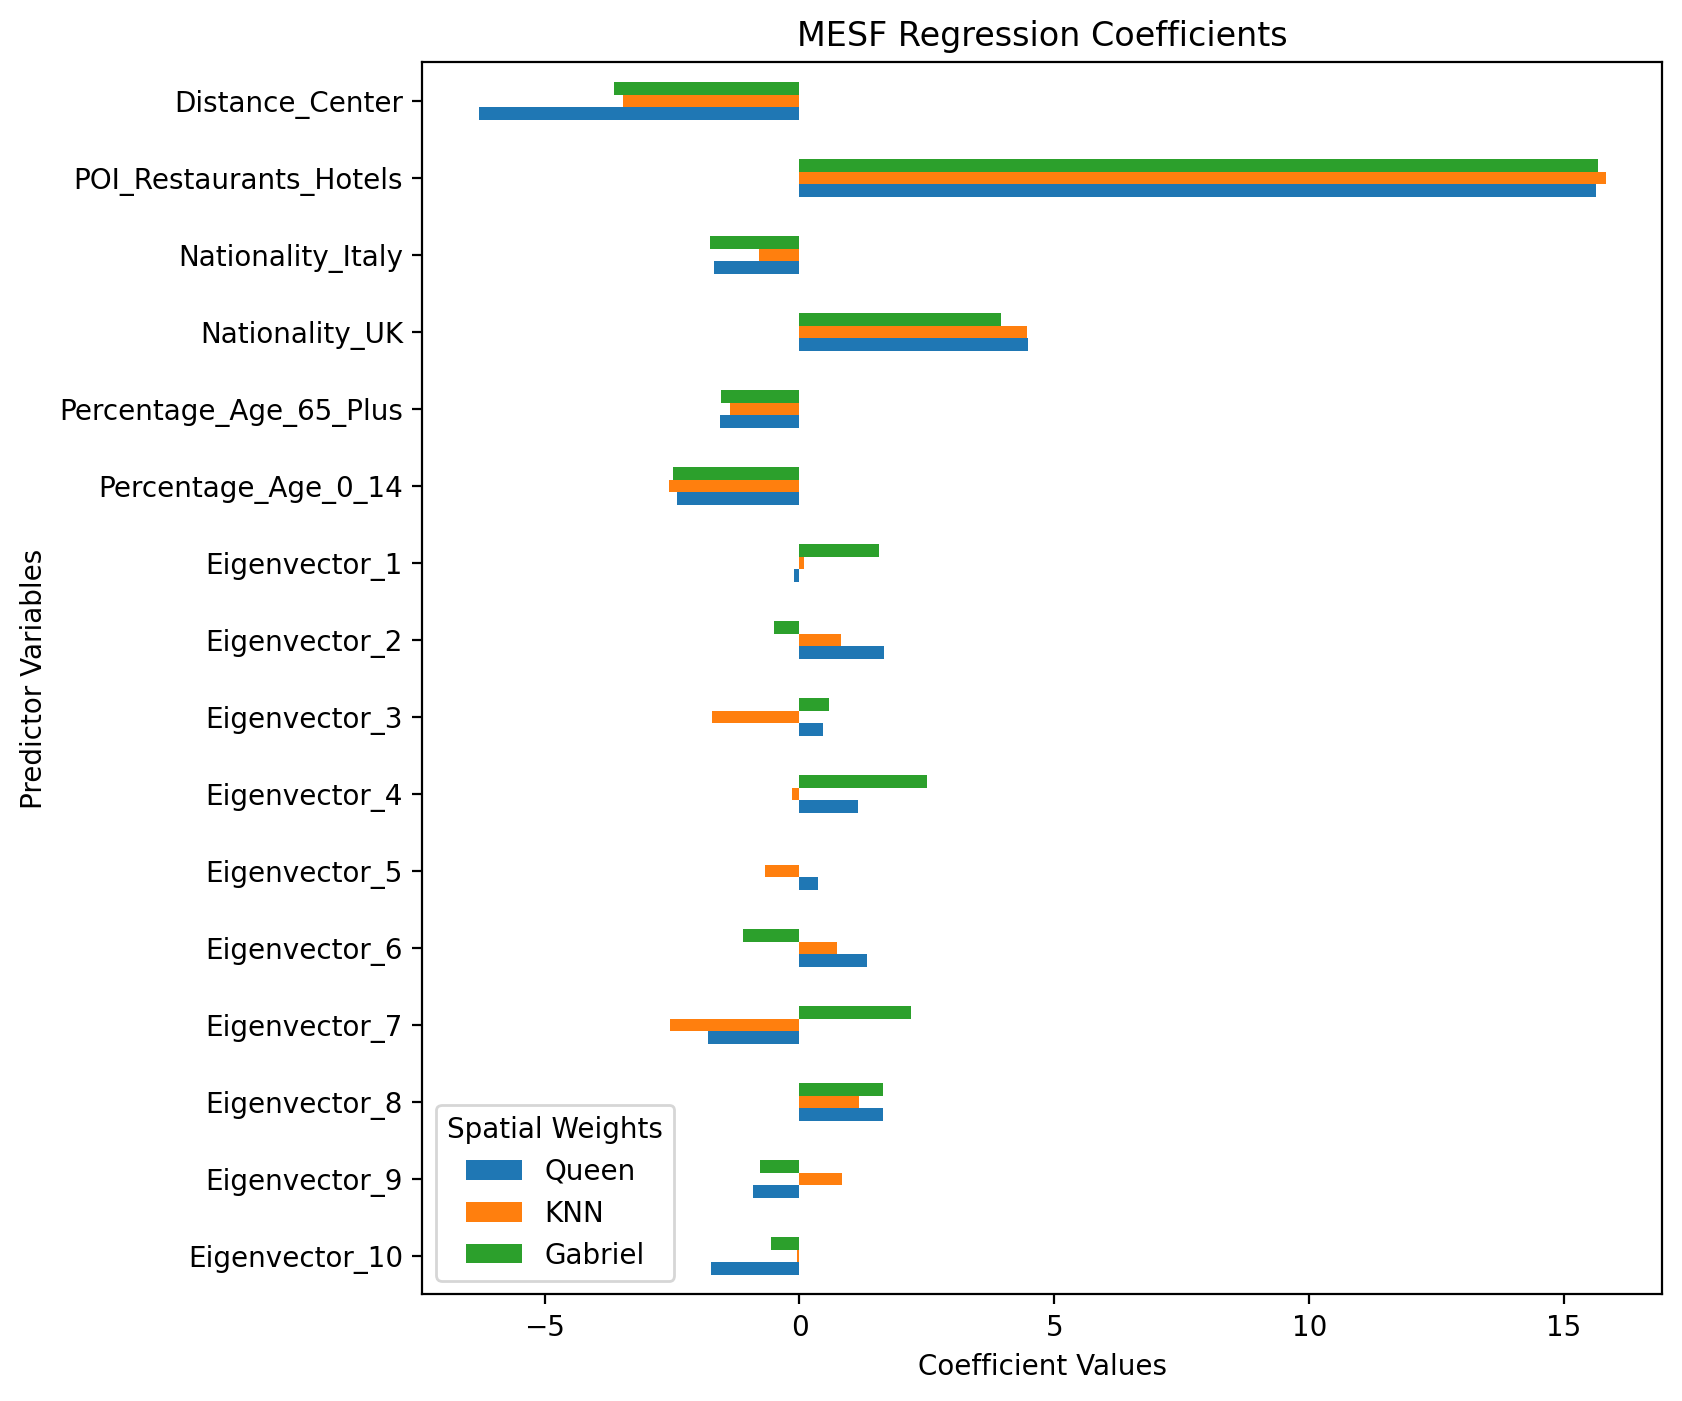

In [47]:
feature_names = X_chosen.columns.tolist()
eigenvector_names = [f"Eigenvector_{i+1}" for i in range(eigenvectors_queen.shape[1])]
feature_names += eigenvector_names

coefficients_queen = model_mesf_queen_red.coef_
coefficients_knn = model_mesf_knn_red.coef_
coefficients_gabriel = model_mesf_gabriel_red.coef_

coef_df = pd.DataFrame(
    {
        "Feature": feature_names,
        "Queen": coefficients_queen,
        "KNN": coefficients_knn,
        "Gabriel": coefficients_gabriel,
    }
)

coef_df = coef_df.iloc[::-1]
coef_df.set_index("Feature").plot(kind="barh", figsize=(8, 8))
plt.title("MESF Regression Coefficients")
plt.xlabel("Coefficient Values")
plt.ylabel("Predictor Variables")
plt.legend(title="Spatial Weights")

SAVE_FIGS = True
if SAVE_FIGS is True:
    plt.savefig(DIR_MESF / "mesf_coefficients.png", format="png")
SAVE_FIGS = False

plt.show()